In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

Preprocessing: Detect face and eyes

In [2]:
img = cv2.imread(r'C:\Users\A\Desktop\Celebrity Image Classfication\dataset\Shahrukh khan\135696547ef00c74e216b6beba64e0b0.jpg')
img.shape

(1309, 736, 3)

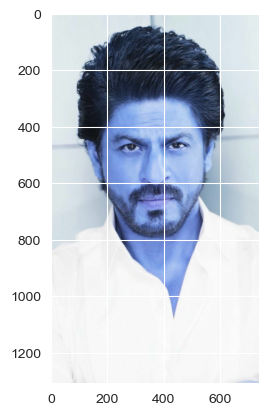

In [3]:
plt.imshow(img)


In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1309, 736)

In [5]:
gray

array([[234, 234, 234, ..., 234, 234, 234],
       [234, 234, 234, ..., 236, 236, 236],
       [234, 234, 233, ..., 236, 236, 236],
       ...,
       [246, 246, 246, ..., 208, 209, 209],
       [246, 246, 246, ..., 204, 205, 205],
       [246, 246, 246, ..., 202, 202, 202]], dtype=uint8)

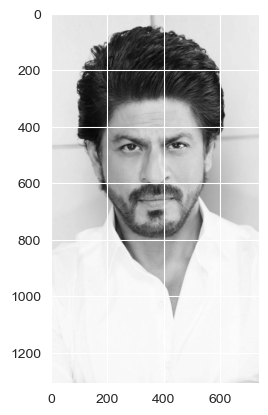

In [6]:
plt.imshow(gray, cmap='gray')

In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[128, 293, 480, 480]])

In [8]:
(x,y,w,h) = faces[0]
x,y,w,h

(128, 293, 480, 480)

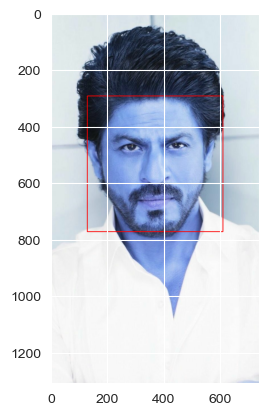

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

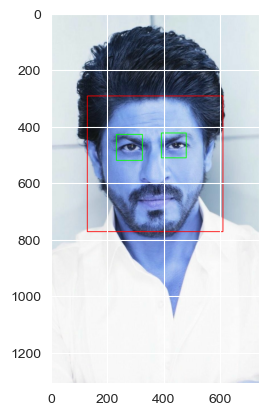

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

 Preprocessing: Crop the facial region of the image

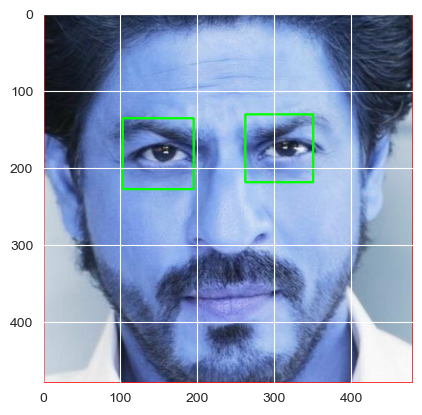

In [11]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region

In [12]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

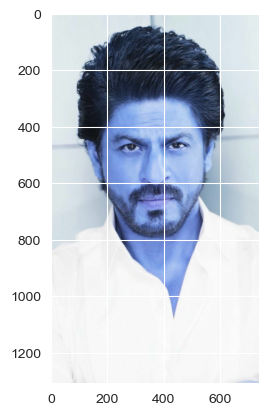

In [13]:
original_image = cv2.imread(r'C:\Users\A\Desktop\Celebrity Image Classfication\dataset\Shahrukh khan\135696547ef00c74e216b6beba64e0b0.jpg')
plt.imshow(original_image)

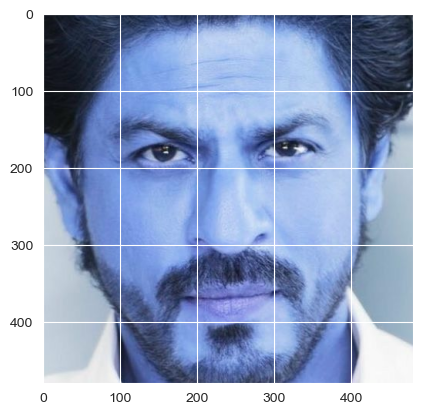

In [14]:
cropped_image = get_cropped_image_if_2_eyes(r'C:\Users\A\Desktop\Celebrity Image Classfication\dataset\Shahrukh khan\135696547ef00c74e216b6beba64e0b0.jpg')
plt.imshow(cropped_image)

In [15]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes(r'C:\Users\A\Desktop\Celebrity Image Classfication\dataset\Shahrukh khan\135696547ef00c74e216b6beba64e0b0.jpg')


Create folder for cropp images

In [16]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [17]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [18]:
img_dirs

['./dataset/cropped',
 './dataset/Shahid Kapoor',
 './dataset/Shahrukh khan',
 './dataset/Tom Cruise']

In [19]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

Generate cropp image

In [20]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

cropped
Shahid Kapoor
Generating cropped images in folder:  ./dataset/cropped/Shahid Kapoor
Shahrukh khan
Generating cropped images in folder:  ./dataset/cropped/Shahrukh khan
Tom Cruise
Generating cropped images in folder:  ./dataset/cropped/Tom Cruise


Preprocessing: Use wavelet transform as a feature for traning our model

In [21]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

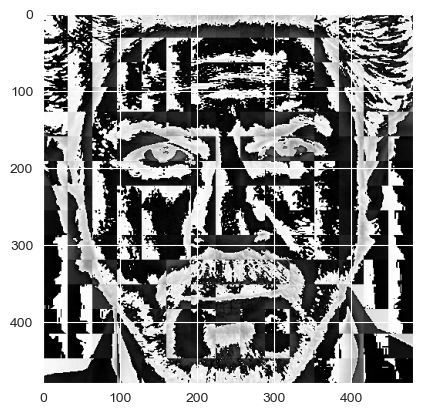

In [22]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [23]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'Shahid Kapoor': ['./dataset/cropped/Shahid Kapoor\\Shahid Kapoor1.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor10.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor11.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor12.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor13.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor14.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor15.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor16.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor17.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor18.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor19.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor2.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor20.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor21.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor22.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor23.png',
  './dataset/cropped/Shahid Kapoor\\Shahid Kapoor24.png',

encoding to folder name

In [24]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Shahid Kapoor': 0, 'Shahrukh khan': 1, 'Tom Cruise': 2}

Train classifier

In [25]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [26]:
len(X[0])

4096

In [27]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(157, 4096)

Trainig the model

In [28]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8

In [30]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.81      0.95      0.88        22
           2       0.50      0.40      0.44         5

    accuracy                           0.80        40
   macro avg       0.74      0.68      0.70        40
weighted avg       0.80      0.80      0.79        40



use GridSearch to try out different models with different paramets for best socre and fine tuning

In [31]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [32]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [33]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.777899,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.624638,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.811957,{'logisticregression__C': 1}


In [34]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, multi_class='auto',
                                     solver='liblinear'))])}

In [35]:
best_estimators['svm'].score(X_test,y_test)


0.875

In [36]:
best_estimators['random_forest'].score(X_test,y_test)


0.6

In [37]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.75

In [38]:
best_clf = best_estimators['svm']

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[10,  2,  1],
       [ 0, 20,  2],
       [ 0,  0,  5]], dtype=int64)

Text(60.222222222222214, 0.5, 'Truth')

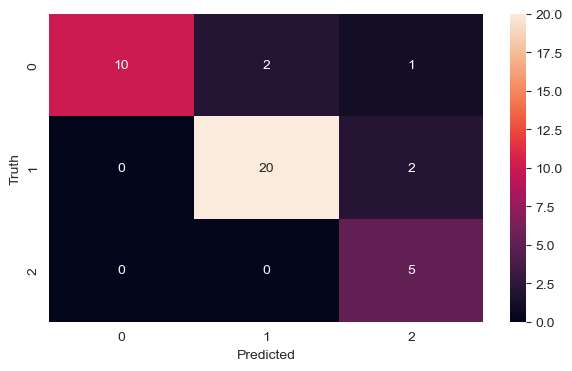

In [40]:
import seaborn as sn
plt.figure(figsize = (7,4))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Save the trained model

In [41]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [42]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

In [ ]:
import base64